Diffusion Limited Aggregation (DLA)

* growth model based on diffusing particles
* started with a single seed
* can be modeled by 
    * solving the time independent diffusion equation (Laplace equation)
    * locating growth candidates around the cluster (north, south, east, west)
    * assigning a growth probability $p_{g}$ for each growth candidate as a function of the concentration of diffusing nutrients at that growth location
    
        $p_{g}(i,j) = c^{\eta}_{i,j}/\sum _{growth candidates} c^{\eta}_{i,j}$

        where $c_{i,j}$ is the concentration at site $(i,j)$
        
        $\eta$ controls the shape of the DLA cluster:
            
        $\eta = 1$ : Standard DLA cluster (branching)

        $\eta < 1$ : More compact ($\eta = 0$ resulting in eden cluster)
        
        $\eta > 1$ : More branched


    * selective a single growth candidate with probability $p_{g}$ and adding it to the cluster
    * re-solving the diffusion equation and repeating the process for the growth steps

In [1]:
%pip install numba

Note: you may need to restart the kernel to use updated packages.Collecting numba
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 3.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 4.2 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.6/30.3 MB 7.6 MB/s eta 0:00:04
   ---- ----------------------------------- 3.4/30.3 MB 8.0 MB/s eta 0:00:04
   ------- -------------------------------- 5.5/30.3 MB 8.8 MB/s eta 0:00:03
   ---------- ----------------------------- 7.9/30.3 MB 9.5 MB/s eta 0:00:03
   ------------- -------------------------- 10.5/30.3 MB 10.1 MB/s eta 0:00:02
   ----------------- ---------------------- 13.4/30.3 MB 10.6 MB/s eta 0:00:02
   ------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.optimize import minimize_scalar
from numba import njit

In [7]:
# params
size = 100
eta = 1
omega = 1.9
tolerance = 1e-5
iterations = 100
steps = 1000

# grid
concentration = np.linspace(1, 0, size).reshape(-1, 1) * np.ones((size, size))
cluster = np.zeros((size, size), dtype=int)
cluster[-1, size // 2] = 1 # one seed, middle of bottom row

The Laplacian operator $\nabla^2$ in two dimensions is defined as:

$\nabla^2 c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}$

For a 2D grid, this can be approximated using finite differences as:

$\nabla^2 c_{i,j} \approx c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}$

This formula tells us that each point in the grid is updated based on its four neighbors


The 5-point stencil can be written as a matrix (convolution kernel):

$$
\begin{bmatrix}
  0 &  1 &  0 \\
  1 & -4 &  1 \\
  0 &  1 &  0
\end{bmatrix}
$$


In [ ]:
# functions
#@njit   
def solve_sor(concentration, cluster, omega, tolerance, iterations):    # initialises laplacian kernel, updates concentration using sor either until max iterations or change is less than tolerance
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])
    
    for _ in range(iterations):
        old_concentration = concentration.copy()
        residual = convolve(concentration, laplacian_kernel, mode='constant')  # this is not compatible with numba
        
        concentration[cluster ==0] += omega * residual[cluster ==0] / 4 # sor update
        
        if np.linalg.norm(concentration - old_concentration) < tolerance:
            break
    return concentration


def find_growth(cluster):   # finds possible growth, NSEW nieghbours of cluster
    padded_cluster = np.pad(cluster, 1, mode='constant') # avoid out of bounds
    candidates = np.zeros_like(padded_cluster)
    neighbours = [(0, 1), (1, 0), (0, -1), (-1, 0)] # north, east, south, west
    
    cluster_shape = cluster.shape
    result_slice = (slice(1, 1 + cluster_shape[0]), slice(1, 1 + cluster_shape[1]))
   
    for dx, dy in neighbours:
        # dynamic slices for looking at neighbors
        neighbour_x = slice(1 + dx, 1 + dx + cluster_shape[0])
        neighbour_y = slice(1 + dy, 1 + dy + cluster_shape[1])
        
       
        neighbour_cluster = padded_cluster[neighbour_x, neighbour_y] == 1   # neighbor cells that are in the cluster
        empty = padded_cluster[result_slice] == 0   # empty cell
        
        candidates[result_slice] |= neighbour_cluster & empty # candidate where empty and has neighbour
    
        
    return np.argwhere(candidates[result_slice])  # remove padding

        
def compute_growth_probabilities(concentration, candidates, eta):
    candidate_concentrations = np.maximum(concentration[candidates[:, 0], candidates[:, 1]], 1e-10)  # Prevent zero values
    weighted_concentrations = candidate_concentrations ** eta
    sum_weighted = np.sum(weighted_concentrations)

    return weighted_concentrations / sum_weighted if sum_weighted > 1e-10 else np.full(len(candidates), 1 / len(candidates))


def simulation(cluster, concentration, steps, eta, omega):
    for _ in range(steps):
        concentration = solve_sor(concentration, cluster, omega, tolerance, iterations)

        candidates = find_growth(cluster)
        if len(candidates) == 0:    # no more candidates
            break

        probability = compute_growth_probabilities(concentration, candidates, eta)

        index = np.random.choice(len(candidates), p=probability) # choose candidate based on probability
        x, y = candidates[index]

        cluster[x, y] = 1

    return cluster, concentration


C:\Users\Thomas\AppData\Local\Temp\ipykernel_34952\2932858521.py:10: RuntimeWarning: overflow encountered in multiply
  concentration[cluster ==0] += omega * residual[cluster ==0] / 4 # sor update
C:\Users\Thomas\AppData\Local\Temp\ipykernel_34952\2932858521.py:10: RuntimeWarning: invalid value encountered in add
  concentration[cluster ==0] += omega * residual[cluster ==0] / 4 # sor update


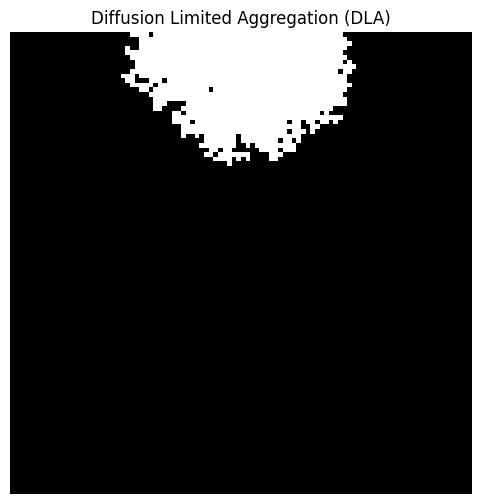

In [9]:
simulation(cluster, concentration, steps, eta, omega)
plt.figure(figsize=(6,6))
plt.imshow(cluster, cmap='gray', origin='lower')
plt.title("Diffusion Limited Aggregation (DLA)")
plt.axis('off')
plt.show()

something fucked up here ? ?